Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 316ms/step - accuracy: 0.5688 - loss: 0.6656 - val_accuracy: 1.0000 - val_loss: 0.4898
Epoch 2/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - accuracy: 1.0000 - loss: 0.4191 - val_accuracy: 1.0000 - val_loss: 0.0851
Epoch 3/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 146ms/step - accuracy: 1.0000 - loss: 0.0606 - val_accuracy: 1.0000 - val_loss: 0.0059
Epoch 4/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step - accuracy: 1.0000 - loss: 0.0046 - val_accuracy: 1.0000 - val_loss: 0.0011
Epoch 5/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 259ms/step - accuracy: 1.0000 - loss: 8.6559e-04 - val_accuracy: 1.0000 - val_loss: 2.9349e-04
Epoch 6/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 243ms/step - accuracy: 1.0000 - loss: 2.4937e-04 - val_accuracy: 1.0000 - val_loss: 1.0571e-04
Epoch 7/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 271ms/step - accuracy: 1.0000 - loss: 9.2657e-05 - val_accuracy: 1.0000 - val_loss: 4.7398e-05
Epoch 8/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 153ms/step - accuracy: 1.0000 - loss: 4.2229e-05 - val_accuracy: 1

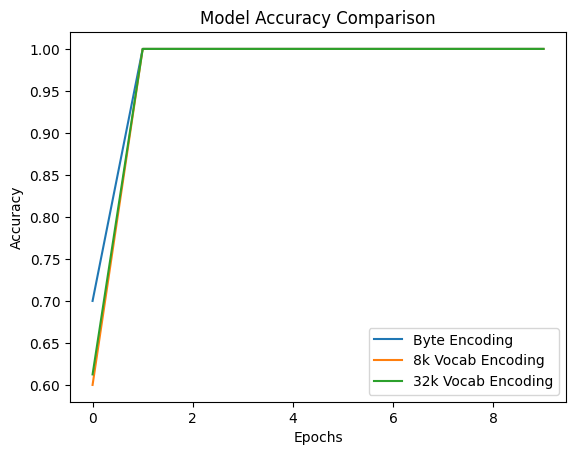

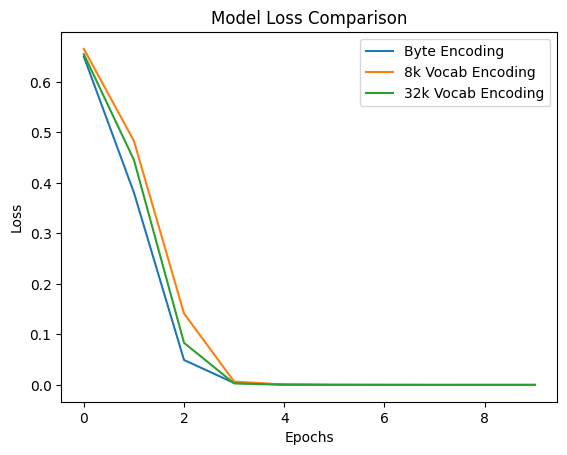

In [2]:
import requests
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

# Step 1: Fetch data from the URL
url = "https://datasets-server.huggingface.co/rows?dataset=stanfordnlp%2Fimdb&config=plain_text&split=train&offset=0&length=100"
response = requests.get(url)
data = response.json()

# Step 2: Extract texts and labels from the JSON data
texts = [row['row']['text'] for row in data['rows']]
labels = [row['row']['label'] for row in data['rows']]

# Convert labels to TensorFlow format
labels = tf.convert_to_tensor(labels, dtype=tf.int32)

# Byte-level encoding
byte_encoder = tfds.deprecated.text.ByteTextEncoder()
byte_encoded_texts = [byte_encoder.encode(text) for text in texts]

# Subword encoding with 8k vocab
subword_encoder_8k = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(texts, target_vocab_size=8000)
subword_encoded_texts_8k = [subword_encoder_8k.encode(text) for text in texts]

# Subword encoding with 32k vocab
subword_encoder_32k = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(texts, target_vocab_size=32000)
subword_encoded_texts_32k = [subword_encoder_32k.encode(text) for text in texts]

# Pad the sequences to the same length
max_length = 256
byte_encoded_texts = tf.keras.preprocessing.sequence.pad_sequences(byte_encoded_texts, maxlen=max_length)
subword_encoded_texts_8k = tf.keras.preprocessing.sequence.pad_sequences(subword_encoded_texts_8k, maxlen=max_length)
subword_encoded_texts_32k = tf.keras.preprocessing.sequence.pad_sequences(subword_encoded_texts_32k, maxlen=max_length)

# Split the dataset into training and validation sets
train_size = int(0.8 * len(texts))
train_data_byte = byte_encoded_texts[:train_size]
train_data_8k = subword_encoded_texts_8k[:train_size]
train_data_32k = subword_encoded_texts_32k[:train_size]
train_labels = labels[:train_size]

val_data_byte = byte_encoded_texts[train_size:]
val_data_8k = subword_encoded_texts_8k[train_size:]
val_data_32k = subword_encoded_texts_32k[train_size:]
val_labels = labels[train_size:]

# Create TensorFlow datasets
train_dataset_byte = tf.data.Dataset.from_tensor_slices((train_data_byte, train_labels)).shuffle(10000).batch(32)
val_dataset_byte = tf.data.Dataset.from_tensor_slices((val_data_byte, val_labels)).batch(32)

train_dataset_8k = tf.data.Dataset.from_tensor_slices((train_data_8k, train_labels)).shuffle(10000).batch(32)
val_dataset_8k = tf.data.Dataset.from_tensor_slices((val_data_8k, val_labels)).batch(32)

train_dataset_32k = tf.data.Dataset.from_tensor_slices((train_data_32k, train_labels)).shuffle(10000).batch(32)
val_dataset_32k = tf.data.Dataset.from_tensor_slices((val_data_32k, val_labels)).batch(32)

# Function to build the model
def build_model(vocab_size):
    model = tf.keras.Sequential([
        tf.keras.layers.Embedding(vocab_size, 128, input_length=max_length),
        tf.keras.layers.Conv1D(128, 5, activation='relu'),
        tf.keras.layers.MaxPooling1D(pool_size=4),
        tf.keras.layers.LSTM(128),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Build and train models for each encoding type
# Byte encoding model
model_byte = build_model(vocab_size=byte_encoder.vocab_size)
history_byte = model_byte.fit(train_dataset_byte, validation_data=val_dataset_byte, epochs=10)

# 8k Subword encoding model
model_8k = build_model(vocab_size=subword_encoder_8k.vocab_size)
history_8k = model_8k.fit(train_dataset_8k, validation_data=val_dataset_8k, epochs=10)

# 32k Subword encoding model
model_32k = build_model(vocab_size=subword_encoder_32k.vocab_size)
history_32k = model_32k.fit(train_dataset_32k, validation_data=val_dataset_32k, epochs=10)

# Generate predictions for the validation set
val_preds_byte = (model_byte.predict(val_dataset_byte) > 0.5).astype(int)
val_preds_8k = (model_8k.predict(val_dataset_8k) > 0.5).astype(int)
val_preds_32k = (model_32k.predict(val_dataset_32k) > 0.5).astype(int)

# Convert TensorFlow tensors to NumPy arrays for scikit-learn
val_labels_np = val_labels.numpy()

# Generate classification reports
print("Byte-level Encoding Classification Report:")
print(classification_report(val_labels_np, val_preds_byte))

print("\n8k Vocab Encoding Classification Report:")
print(classification_report(val_labels_np, val_preds_8k))

print("\n32k Vocab Encoding Classification Report:")
print(classification_report(val_labels_np, val_preds_32k))

# Plotting training and validation accuracy
plt.plot(history_byte.history['accuracy'], label='Byte Encoding')
plt.plot(history_8k.history['accuracy'], label='8k Vocab Encoding')
plt.plot(history_32k.history['accuracy'], label='32k Vocab Encoding')
plt.legend()
plt.title('Model Accuracy Comparison')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

# Plotting training and validation loss
plt.plot(history_byte.history['loss'], label='Byte Encoding')
plt.plot(history_8k.history['loss'], label='8k Vocab Encoding')
plt.plot(history_32k.history['loss'], label='32k Vocab Encoding')
plt.legend()
plt.title('Model Loss Comparison')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()
